In [2]:
#Basic Setting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
warnings.filterwarnings('ignore')
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_percentage_error

#VAR Model
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')


nbi_df = pd.read_csv('/Users/lokheilee/python/fyp/Other Model/monthly_stock_prices_20250325.csv', parse_dates=[0],index_col=0, date_parser=parser)
nbi_df = nbi_df.asfreq(pd.infer_freq(nbi_df.index))
nbi_df = nbi_df.dropna(axis=1, how='any')
nbi_df

,GILD,ILMN,INVA,ACAD,ALKS,ALNY,AMGN,AMRN,ANIP,ARWR,...,ORKA,REGN,RIGL,SIGA,SNY,SRPT,UTHR,VCEL,VRTX,VTRS
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,5.868604,4.713035,13.526764,7.070000,12.670000,7.000000,43.419170,32.500000,202.679993,38.000000,...,770901.687500,7.190759,191.899994,1.318129,17.429871,15.780000,21.334999,539.200012,10.170000,13.707716
2005-02-28,6.125688,4.022374,13.511758,7.520000,11.670000,7.150000,42.979675,26.799999,181.800003,40.400002,...,758215.937500,6.102159,186.399994,1.213002,18.689577,15.660000,22.715000,404.799988,11.540000,14.507263
2005-03-31,6.347311,3.929961,13.691813,6.900000,10.380000,7.330000,40.607807,21.400000,144.000000,38.500000,...,634286.187500,5.103442,160.399994,1.035095,19.827528,15.000000,22.850000,332.799988,9.360000,14.630795
2005-04-30,6.579574,4.776265,13.279183,7.460000,11.250000,7.780000,40.607807,19.299999,140.039993,27.500000,...,568905.937500,5.562851,171.500000,0.865275,20.778164,16.020000,23.995001,320.000000,9.530000,13.623487
2005-05-31,7.233807,5.107004,13.196659,8.730000,11.600000,7.460000,43.656364,13.400000,133.199997,27.400000,...,724062.062500,6.222004,178.899994,1.107876,21.073187,14.160000,24.980000,438.399994,13.920000,13.623487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-30,91.168472,144.149994,18.990000,16.320000,29.020000,253.070007,280.602997,0.510000,57.230000,26.030001,...,21.730000,749.257141,27.610001,7.280000,48.490002,133.339996,370.489990,58.139999,468.130005,12.927222
2024-12-31,91.726227,133.630005,17.350000,18.350000,28.760000,235.309998,258.551178,0.490000,55.279999,18.799999,...,19.389999,711.415833,16.820000,6.010000,48.230000,121.589996,352.839996,54.910000,402.700012,12.295181
2025-01-31,96.522552,132.740005,18.639999,18.660000,31.530001,271.309998,283.132568,0.580000,58.639999,19.879999,...,13.450000,672.116272,21.650000,5.980000,54.340000,113.720001,351.170013,58.540001,461.679993,11.139730


In [4]:
# Initialize a clean DataFrame with the same index
nbi_clean_df = pd.DataFrame(index=nbi_df.index)

for column in nbi_df.columns:
    stock_series = nbi_df[column].copy()
    
    # Normalization (Z-score)
    avg = stock_series.mean()
    dev = stock_series.std()
    stock_series = (stock_series - avg) / dev
    
    # First Difference (remove trend)
    stock_series = stock_series.diff().dropna()
    
    # Remove Volatility (annual scaling)
    annual_volatility = stock_series.groupby(stock_series.index.year).std()
    stock_annual_vol = stock_series.index.map(lambda d: annual_volatility.loc[d.year])
    stock_series = stock_series / stock_annual_vol
    
    # Remove Seasonality (monthly adjustment)
    month_avg = stock_series.groupby(stock_series.index.month).mean()
    stock_month_avg = stock_series.index.map(lambda d: month_avg.loc[d.month])
    stock_series = stock_series - stock_month_avg
    
    # Store the processed series in nbi_clean_df (original column name)
    nbi_clean_df[column] = stock_series

In [5]:
nbi_clean_df = nbi_clean_df.dropna()
nbi_clean_df

,GILD,ILMN,INVA,ACAD,ALKS,ALNY,AMGN,AMRN,ANIP,ARWR,...,ORKA,REGN,RIGL,SIGA,SNY,SRPT,UTHR,VCEL,VRTX,VTRS
Date,,,,,,,,,,,,,,,,,,,,,
2005-02-28,0.777551,-0.915868,-0.138544,0.195655,-0.759269,0.177205,0.029390,-1.852607,-1.376656,0.712433,...,0.144612,-0.591344,-0.204464,-0.933335,1.612236,0.016316,0.688143,-1.737763,0.670328,0.819273
2005-03-31,0.202010,-0.250328,0.142906,-0.332491,-0.644154,0.208698,-0.652838,-1.657170,-1.951573,-0.385132,...,-0.939480,-0.763882,-0.616403,-1.086583,0.441531,-0.166484,0.238689,-1.041459,-1.277852,0.231506
2005-04-30,0.693612,1.150347,-0.466846,0.731662,0.648798,0.467805,-0.032031,-0.714009,-0.366207,-2.407559,...,-0.629177,0.205613,0.364771,-1.297166,0.501128,0.493348,0.441053,-0.064640,-0.249902,-0.761904
2005-05-31,1.642891,0.421794,-0.103550,1.259624,0.221006,-0.373777,0.696313,-1.710892,-0.100244,0.263000,...,1.768341,-0.051053,0.518571,1.572935,-0.108380,-1.019333,0.227351,1.772507,1.794374,0.198061
2005-06-30,1.121728,0.667785,-0.394954,-0.134908,0.725818,-0.419759,-0.508009,-0.481174,-0.024711,-0.004240,...,0.704331,1.253979,0.305036,-1.171196,-1.434870,-0.349588,-0.414336,0.858546,0.976956,2.256228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-30,0.499665,-0.229456,-0.813783,0.512665,1.433754,-0.848906,-1.695544,-0.753638,-0.354752,1.276614,...,-1.050353,-1.188958,2.148888,-0.039067,-1.497097,0.561983,-0.592710,2.051778,-0.290967,1.299121
2024-12-31,0.130038,-1.213559,-1.847762,0.529810,-0.536978,-0.645704,-0.971293,-0.143615,-0.318985,-1.739527,...,-0.221912,-0.595752,-1.869871,-0.716160,-0.496023,-0.885597,-1.170547,-0.580207,-2.185286,-1.056886
2025-01-31,-0.118297,-0.560630,1.268407,0.154681,1.311261,0.891831,1.627286,0.512657,7.823595,0.685789,...,-1.332425,-1.002263,1.277915,0.079077,2.055043,-0.525157,-0.048481,0.369688,2.381120,-1.386535


In [6]:
column_names = nbi_clean_df.columns.tolist()
print("Columns with complete data (no missing values):")
print(column_names)

Columns with complete data (no missing values):
['GILD', 'ILMN', 'INVA', 'ACAD', 'ALKS', 'ALNY', 'AMGN', 'AMRN', 'ANIP', 'ARWR', 'AVDL', 'AZN', 'BCRX', 'BIIB', 'BMRN', 'CYTK', 'DVAX', 'EXEL', 'EYPT', 'GERN', 'HALO', 'INCY', 'INSM', 'IONS', 'LGND', 'LXRX', 'MNKD', 'NBIX', 'NVAX', 'ORKA', 'REGN', 'RIGL', 'SIGA', 'SNY', 'SRPT', 'UTHR', 'VCEL', 'VRTX', 'VTRS']


In [7]:
#VAR with proper lag
from sklearn.model_selection import TimeSeriesSplit

# 24-month test size (2 years) for meaningful monthly evaluation
tscv = TimeSeriesSplit(n_splits=3, test_size=24)
rmse_results = []

for lag in range(1, 14):  # Test lags 1-13 months
    fold_rmses = []
    for train_idx, test_idx in tscv.split(nbi_clean_df):
        train = nbi_clean_df.iloc[train_idx]
        test = nbi_clean_df.iloc[test_idx]
        
        model = VAR(train).fit(maxlags=lag)
        forecast = model.forecast(train.values[-lag:], steps=len(test_idx))
        fold_rmses.append(np.sqrt(mean_squared_error(test, forecast)))
    
    rmse_results.append({'Lag': lag, 'RMSE': np.mean(fold_rmses)})

rmse_df = pd.DataFrame(rmse_results)
rmse_df

,Lag,RMSE
0,1,1.022715
1,2,1.058264
2,3,1.153502
3,4,3.576900
4,5,6.431068
5,6,3.584769
6,7,2.196734
7,8,1.805421
8,9,1.588531
9,10,1.471594


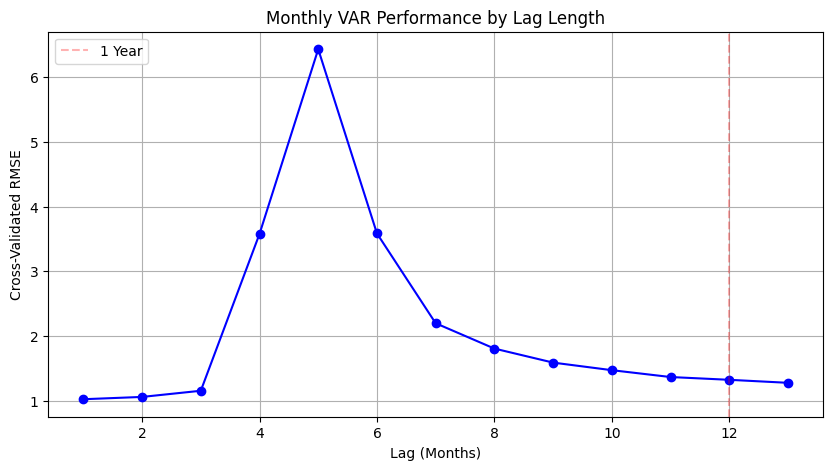

In [8]:
plt.figure(figsize=(10,5))
plt.plot(rmse_df['Lag'], rmse_df['RMSE'], 'bo-')
plt.axvline(12, color='r', linestyle='--', alpha=0.3, label='1 Year')
plt.xlabel('Lag (Months)')
plt.ylabel('Cross-Validated RMSE')
plt.title('Monthly VAR Performance by Lag Length')
plt.legend()
plt.grid(True)
plt.show()

Preparing data...

Fitting VAR model...

VAR Model Summary:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 26, Mar, 2025
Time:                     23:32:58
--------------------------------------------------------------------
No. of Equations:         39.0000    BIC:                    73.8455
Nobs:                     226.000    HQIC:                   18.5720
Log likelihood:          -4256.09    FPE:                 0.00209239
AIC:                     -18.8268    Det(Omega_mle):     2.43288e-12
--------------------------------------------------------------------
Results for equation GILD
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const          -0.055350         0.066751           -0.829           0.407
L1.GILD         0.003284         0.139573            0.024           0.981
L1.ILMN        -0.224223 

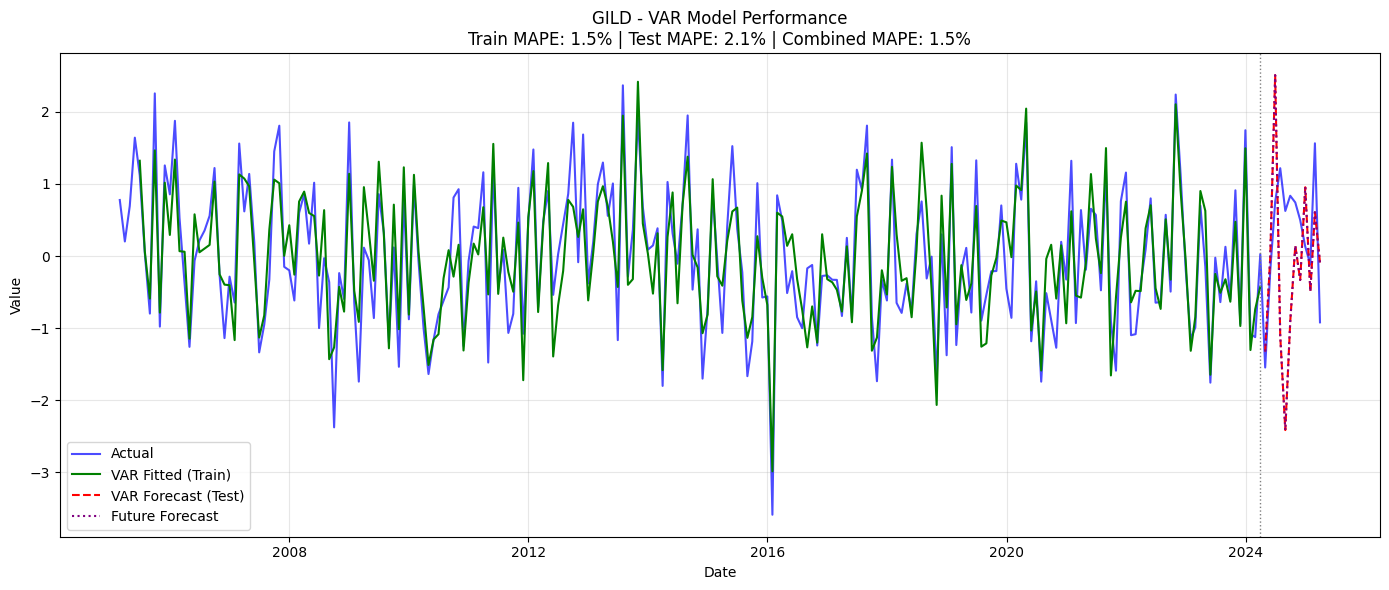

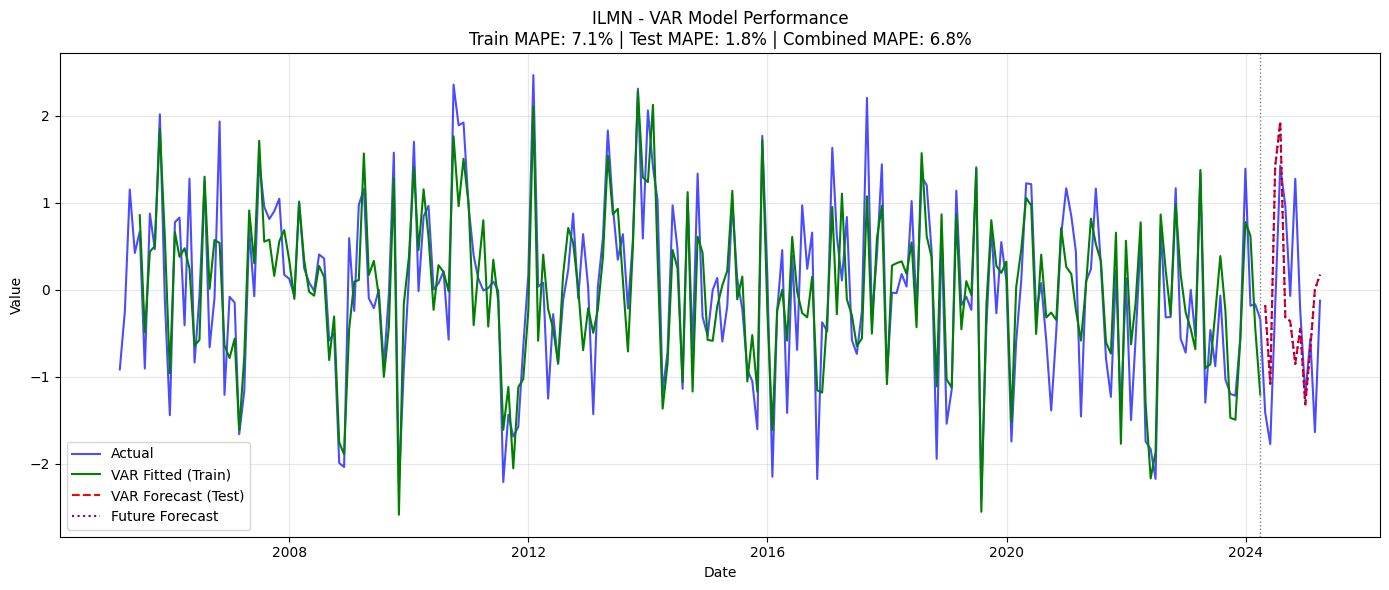

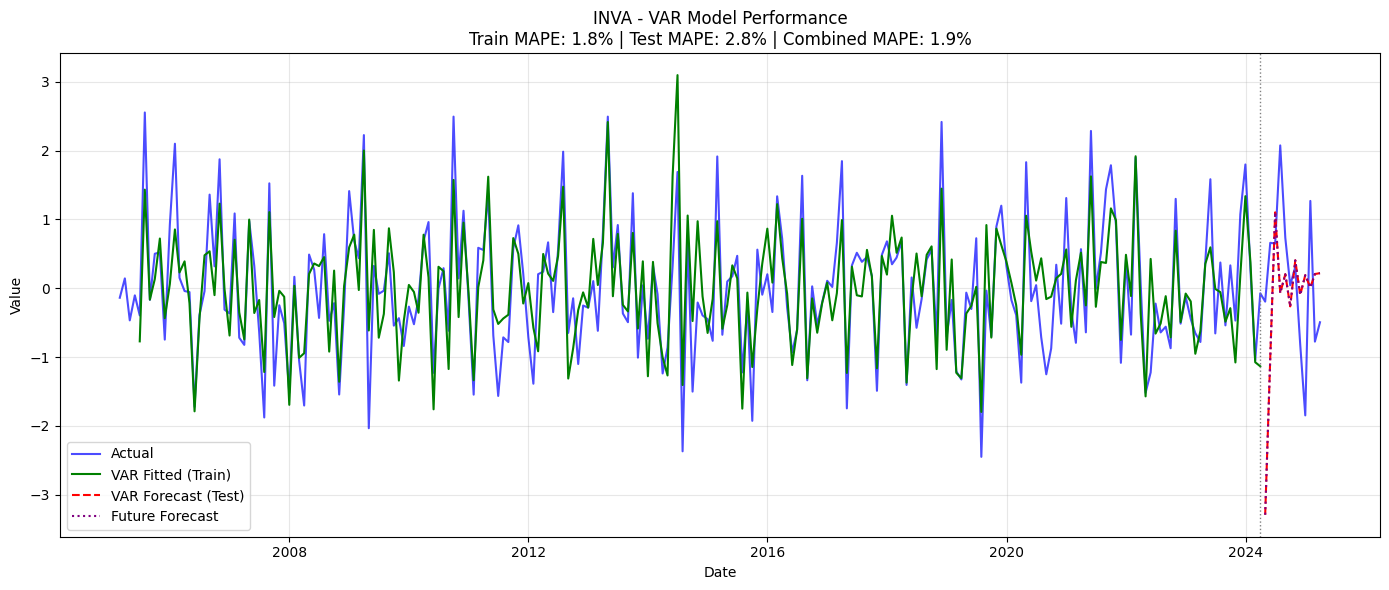


VAR analysis complete!


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

# =================================================================
# 0. Configuration
# =================================================================
VAR_MAXLAGS = 4               # Lag order for VAR model
TEST_SIZE = 12                # Months for backtesting
FORECAST_STEPS = 12           # Months for future forecasting
PLOT_COLS = 3                 # Number of top stocks to visualize
SIG_LEVEL = 0.05              # Significance threshold for variable selection

# =================================================================
# 1. Data Preparation
# =================================================================
print("Preparing data...")
scaler = StandardScaler()
nbi_scaled = pd.DataFrame(
    scaler.fit_transform(nbi_clean_df),
    columns=nbi_clean_df.columns,
    index=nbi_clean_df.index
)

# Split into training and testing
train = nbi_scaled.iloc[:-TEST_SIZE]
test = nbi_scaled.iloc[-TEST_SIZE:]

# =================================================================
# 2. VAR Model Fitting
# =================================================================
print("\nFitting VAR model...")
model = VAR(train)
var_results = model.fit(maxlags=VAR_MAXLAGS, ic='aic')

# Display summary
print("\nVAR Model Summary:")
print("="*60)
print(var_results.summary())

# =================================================================
# 3. Model Diagnostics
# =================================================================
print("\nRunning model diagnostics...")
residuals = pd.DataFrame(var_results.resid, columns=train.columns)

# Ljung-Box test for autocorrelation
print("\nResidual Autocorrelation Test (Ljung-Box):")
for col in residuals.columns[:3]:  # First 3 only for display
    lb_test = acorr_ljungbox(residuals[col], lags=[4], return_df=True)
    print(f"{col}: Q-stat = {lb_test['lb_stat'].iloc[0]:.2f}, p-value = {lb_test['lb_pvalue'].iloc[0]:.4f}")

# Stability check
print("\nModel Stability Check:")
roots = np.abs(var_results.roots)
print(f"Roots of characteristic polynomial:\n{roots}")
print("All roots < 1?:", all(roots < 1))

# =================================================================
# 4. Significant Variable Selection
# =================================================================
print("\nSelecting significant variables...")
pvalues = var_results.pvalues.max(axis=1)
significant_vars = [var for var in pvalues[pvalues <= SIG_LEVEL].index 
                   if var in train.columns and var != 'const']

if len(significant_vars) == 0:
    print(f"No variables significant at p ≤ {SIG_LEVEL}. Using all variables.")
    significant_vars = train.columns.tolist()
elif len(significant_vars) < len(train.columns):
    print(f"Keeping significant variables (p ≤ {SIG_LEVEL}): {significant_vars}")
else:
    print("All variables are statistically significant")

# =================================================================
# 5. Backtesting with MAPE Table
# =================================================================
def calculate_mape_table(results, train, test, original_df, scaler, vars_to_use):
    """Calculate MAPE and return results in DataFrame format."""
    if len(vars_to_use) == 0:
        raise ValueError("No variables selected for forecasting")
    
    # Training fitted values
    train_fitted = results.fittedvalues[vars_to_use]
    train_forecast = pd.DataFrame(
        scaler.inverse_transform(train_fitted),
        columns=vars_to_use,
        index=train.index[results.k_ar:]
    )
    
    # Testing forecasts
    test_forecast_values = results.forecast(
        train[vars_to_use].values[-results.k_ar:], 
        steps=TEST_SIZE
    )
    test_forecast = pd.DataFrame(
        scaler.inverse_transform(test_forecast_values),
        columns=vars_to_use,
        index=test.index
    )
    
    # Initialize results dictionary
    mape_results = {
        'Variable': [],
        'Train_MAPE': [],
        'Test_MAPE': [],
        'Combined_MAPE': []
    }
    
    for col in vars_to_use:
        # Training MAPE
        train_true = original_df.loc[train_forecast.index, col].replace(0, 1e-10)
        train_pred = train_forecast[col]
        train_mape = mean_absolute_percentage_error(train_true, train_pred)
        
        # Testing MAPE
        test_true = original_df.loc[test_forecast.index, col].replace(0, 1e-10)
        test_pred = test_forecast[col]
        test_mape = mean_absolute_percentage_error(test_true, test_pred)
        
        # Combined MAPE (weighted average)
        n_train = len(train_true)
        n_test = len(test_true)
        combined_mape = (train_mape * n_train + test_mape * n_test) / (n_train + n_test)
        
        # Store results
        mape_results['Variable'].append(col)
        mape_results['Train_MAPE'].append(train_mape)
        mape_results['Test_MAPE'].append(test_mape)
        mape_results['Combined_MAPE'].append(combined_mape)
    
    # Create DataFrame
    mape_df = pd.DataFrame(mape_results)
    mape_df = mape_df.round(2)
    
    return mape_df, pd.concat([train_forecast, test_forecast])

print("\nCalculating MAPE table...")
mape_df, full_forecast = calculate_mape_table(
    var_results, train, test, nbi_clean_df, scaler, significant_vars
)

# Display the MAPE table
print("\nMAPE Results (%):")
print("="*60)
print(mape_df.to_string(index=False))
print("="*60)

# =================================================================
# 6. Future Forecasting
# =================================================================
print(f"\nGenerating {FORECAST_STEPS}-month forecasts...")
future_forecast_values = var_results.forecast(
    train[significant_vars].values[-var_results.k_ar:],
    steps=FORECAST_STEPS
)
future_forecast = pd.DataFrame(
    scaler.inverse_transform(future_forecast_values),
    columns=significant_vars,
    index=pd.date_range(
        start=train.index[-1] + pd.offsets.MonthBegin(1),
        periods=FORECAST_STEPS,
        freq='M'
    )
)

print("\nFuture Forecasts:")
print(future_forecast.head().round(2))

# =================================================================
# 7. Enhanced Visualization with Complete MAPE Display
# =================================================================
def plot_var_results(col, actual_df, forecast_df, future_df, train_end, mape_df):
    """Enhanced visualization showing all three MAPE values"""
    plt.figure(figsize=(14, 6))
    
    # Get all MAPE values from the dataframe
    row = mape_df[mape_df['Variable'] == col].iloc[0]
    train_mape = row['Train_MAPE']
    test_mape = row['Test_MAPE']
    combined_mape = row['Combined_MAPE']
    
    # Plot actual values
    plt.plot(actual_df.index, actual_df[col], 
             label='Actual', color='blue', alpha=0.7)
    
    # Plot training period fits
    train_fit = forecast_df[forecast_df.index <= train_end]
    plt.plot(train_fit.index, train_fit[col],
             label='VAR Fitted (Train)', color='green', linestyle='-')
    
    # Plot testing period forecasts
    test_fcst = forecast_df[forecast_df.index > train_end]
    plt.plot(test_fcst.index, test_fcst[col],
             label='VAR Forecast (Test)', color='red', linestyle='--')
    
    # Plot future forecasts
    plt.plot(future_df.index, future_df[col],
             label='Future Forecast', color='purple', linestyle=':')
    
    # Add formatting
    plt.axvline(x=train_end, color='gray', linestyle=':', linewidth=1)
    plt.title(
        f"{col} - VAR Model Performance\n"
        f"Train MAPE: {train_mape:.1f}% | "
        f"Test MAPE: {test_mape:.1f}% | "
        f"Combined MAPE: {combined_mape:.1f}%"
    )
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("\nGenerating visualizations...")
# Plot first PLOT_COLS variables in their original order
for col in mape_df['Variable'].iloc[:PLOT_COLS]:
    plot_var_results(
        col=col,
        actual_df=nbi_clean_df,
        forecast_df=full_forecast,
        future_df=future_forecast,
        train_end=train.index[-1],
        mape_df=mape_df
    )

print("\nVAR analysis complete!")

In [13]:

import scipy.stats as stats
def display_var_results(results, vars_per_section=3, sig_only=True):
    """
    Display VAR results with:
    - Coefficient estimates
    - Standard errors
    - z-statistics
    - p-values
    - Significance stars
    Only shows significant results (p < 0.05) if sig_only=True
    """
    # Create a DataFrame with all results
    coeffs = []
    for eq in results.names:
        for var in results.params.index:
            coef = results.params.loc[var, eq]
            std_err = results.bse.loc[var, eq]
            z = coef / std_err
            p = 2 * (1 - stats.norm.cdf(abs(z)))  # Two-tailed p-value
            
            # Skip if not significant and sig_only is True
            if sig_only and p >= 0.05:
                continue
                
            coeffs.append({
                'Equation': eq,
                'Variable': var,
                'Coefficient': coef,
                'Std.Error': std_err,
                'z-value': z,
                'p-value': p,
                'Significance': get_sig_stars(p)
            })
    
    df = pd.DataFrame(coeffs)
    
    if len(df) == 0:
        print("\nNo significant results found (p < 0.05)")
        return
        
    # Split display by equations
    equations = df['Equation'].unique()
    for i in range(0, len(equations), vars_per_section):
        current_eqs = equations[i:i+vars_per_section]
        print(f"\n{'='*80}")
        print(f"SIGNIFICANT VAR RESULTS (p < 0.05) FOR EQUATIONS: {', '.join(current_eqs)}")
        print(f"{'='*80}\n")
        
        # Display each equation's results
        for eq in current_eqs:
            eq_df = df[df['Equation'] == eq].drop('Equation', axis=1)
            if len(eq_df) > 0:  # Only display if there are significant results
                print(f"\nEquation: {eq}")
                print("-"*60)
                print(eq_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
                print("\n" + "-"*60)
        
        print(f"\n{'='*80}")

def get_sig_stars(p):
    """Return significance stars"""
    if p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    elif p < 0.1: return '.'
    return ''

# Usage example:
var_model = VAR(nbi_scaled)
results = var_model.fit(maxlags=4)
display_var_results(results)


SIGNIFICANT VAR RESULTS (p < 0.05) FOR EQUATIONS: GILD, ILMN, INVA


Equation: GILD
------------------------------------------------------------
Variable  Coefficient  Std.Error  z-value  p-value Significance
 L1.UTHR       0.2607     0.1112   2.3447   0.0190            *
 L2.BMRN       0.2351     0.1191   1.9738   0.0484            *
 L2.DVAX      -0.2173     0.1061  -2.0491   0.0405            *
 L2.MNKD       0.2306     0.1139   2.0247   0.0429            *
  L2.SNY       0.2223     0.1045   2.1276   0.0334            *
 L2.SRPT      -0.3266     0.1048  -3.1157   0.0018           **
 L2.VRTX      -0.2242     0.1039  -2.1579   0.0309            *
 L2.VTRS       0.2372     0.0971   2.4431   0.0146            *
 L3.DVAX       0.2010     0.0932   2.1577   0.0309            *
 L3.HALO      -0.2996     0.1305  -2.2962   0.0217            *
 L3.NBIX       0.2348     0.1041   2.2560   0.0241            *
 L4.ANIP      -0.3462     0.1430  -2.4212   0.0155            *
 L4.LGND       0.2518 

In [20]:
import scipy.stats as stats
import pandas as pd
import numpy as np
from collections import defaultdict

def extract_lag(var_name):
    """Safely extract lag from variable name"""
    try:
        parts = var_name.split('.')
        for part in parts:
            if part.startswith('L') and part[1:].isdigit():
                return int(part[1:])
        return 0
    except:
        return 0

def analyze_stock_relationships(results, significance_level=0.05):
    """
    Analyze direct and indirect relationships between stocks based on VAR results
    """
    direct_effects = defaultdict(list)
    
    # Get unique stock names
    unique_stocks = set(name.split('.')[0] for name in results.names)
    
    # Analyze direct relationships
    for eq in results.names:
        eq_name = eq.split('.')[0]  # Get base stock name
        for var in results.params.index:
            base_var = var.split('.')[0]  # Get base stock name
            
            coef = results.params.loc[var, eq]
            std_err = results.bse.loc[var, eq]
            z = coef / std_err
            p = 2 * (1 - stats.norm.cdf(abs(z)))
            
            # Only consider significant relationships
            if p < significance_level:
                lag = extract_lag(var)
                
                if base_var != eq_name:  # Ignore self-relationships
                    relationship = {
                        'from': base_var,
                        'to': eq_name,
                        'coefficient': coef,
                        'p_value': p,
                        'lag': lag
                    }
                    direct_effects[base_var].append(relationship)
    
    # Calculate indirect relationships
    indirect_effects = defaultdict(list)
    for stock1 in unique_stocks:
        for stock2 in unique_stocks:
            if stock1 != stock2:
                # Check if there's a direct effect
                has_direct = any(rel['to'] == stock2 for rel in direct_effects[stock1])
                
                # Look for indirect paths
                if not has_direct:
                    indirect_paths = []
                    for intermediate in unique_stocks:
                        if (intermediate != stock1 and intermediate != stock2 and
                            any(rel['to'] == intermediate for rel in direct_effects[stock1]) and
                            any(rel['to'] == stock2 for rel in direct_effects[intermediate])):
                            indirect_paths.append([stock1, intermediate, stock2])
                    
                    if indirect_paths:
                        indirect_effects[stock1].append({
                            'to': stock2,
                            'paths': indirect_paths
                        })
    
    return direct_effects, indirect_effects

def calculate_network_metrics(direct_effects):
    """Calculate network metrics for each stock"""
    metrics = {
        'outgoing_connections': defaultdict(int),
        'incoming_connections': defaultdict(int),
        'total_impact': defaultdict(float)
    }
    
    # Calculate metrics
    for source, relationships in direct_effects.items():
        for rel in relationships:
            metrics['outgoing_connections'][source] += 1
            metrics['incoming_connections'][rel['to']] += 1
            metrics['total_impact'][source] += abs(rel['coefficient'])
    
    # Create DataFrame
    stocks = set()
    for source, rels in direct_effects.items():
        stocks.add(source)
        for rel in rels:
            stocks.add(rel['to'])
    
    data = []
    for stock in stocks:
        outgoing = metrics['outgoing_connections'][stock]
        data.append({
            'stock': stock,
            'outgoing': outgoing,
            'incoming': metrics['incoming_connections'][stock],
            'total_impact': metrics['total_impact'][stock],
            'avg_impact': metrics['total_impact'][stock] / outgoing if outgoing > 0 else 0
        })
    
    return pd.DataFrame(data).set_index('stock')

def display_results(direct_effects, indirect_effects):
    """Display the analysis results"""
    # Display direct relationships
    print("\n=== DIRECT RELATIONSHIPS ===")
    print("Showing significant relationships (p < 0.05):")
    
    for source, relationships in sorted(direct_effects.items()):
        if relationships:
            print(f"\n{source} affects:")
            # Group by target and lag
            target_effects = defaultdict(list)
            for rel in relationships:
                target_effects[rel['to']].append(rel)
            
            for target, effects in sorted(target_effects.items()):
                total_coef = sum(rel['coefficient'] for rel in effects)
                lags = sorted(rel['lag'] for rel in effects)
                sign = '+' if total_coef > 0 else '-'
                print(f"  → {target} ({sign}{abs(total_coef):.4f}, lags: {lags})")
    
    # Display indirect relationships
    if any(indirect_effects.values()):
        print("\n=== INDIRECT RELATIONSHIPS ===")
        for source, relationships in sorted(indirect_effects.items()):
            if relationships:
                print(f"\n{source} indirectly affects:")
                for rel in relationships:
                    print(f"  → {rel['to']} through:")
                    for path in rel['paths']:
                        print(f"    {' → '.join(path)}")
    else:
        print("\n=== INDIRECT RELATIONSHIPS ===")
        print("No significant indirect relationships found")
    
    # Calculate and display network metrics
    metrics_df = calculate_network_metrics(direct_effects)
    
    print("\n=== NETWORK METRICS ===")
    print("\nAll stocks metrics:")
    print(metrics_df.sort_values(['outgoing', 'incoming'], ascending=[False, False]).round(4))
    
    print("\nTop 5 Most Influential Stocks (highest outgoing connections):")
    print(metrics_df.nlargest(5, 'outgoing')[['outgoing', 'avg_impact']].round(4))
    
    print("\nTop 5 Most Influenced Stocks (highest incoming connections):")
    print(metrics_df.nlargest(5, 'incoming')[['incoming']].round(4))

# Usage example:
direct_effects, indirect_effects = analyze_stock_relationships(results)
display_results(direct_effects, indirect_effects)


=== DIRECT RELATIONSHIPS ===
Showing significant relationships (p < 0.05):

L1 affects:
  → ACAD (-0.2800, lags: [1])
  → ALKS (+0.0303, lags: [1, 1, 1, 1, 1, 1])
  → ALNY (+0.1175, lags: [1, 1])
  → AMGN (-0.3222, lags: [1])
  → AMRN (+0.5854, lags: [1, 1])
  → ANIP (-0.0423, lags: [1, 1])
  → ARWR (+0.9294, lags: [1, 1, 1, 1, 1])
  → AVDL (-0.2973, lags: [1])
  → AZN (-0.8285, lags: [1, 1, 1])
  → BCRX (-0.2732, lags: [1])
  → BIIB (-0.6014, lags: [1, 1])
  → BMRN (+0.0350, lags: [1, 1, 1, 1, 1])
  → CYTK (+0.2610, lags: [1, 1, 1, 1, 1, 1, 1, 1])
  → DVAX (-0.0178, lags: [1, 1])
  → EXEL (+0.2911, lags: [1, 1, 1])
  → EYPT (-0.2987, lags: [1, 1, 1, 1, 1])
  → GERN (-0.3256, lags: [1])
  → GILD (+0.2607, lags: [1])
  → HALO (-0.6834, lags: [1, 1, 1])
  → ILMN (-0.0008, lags: [1, 1, 1, 1])
  → INCY (+0.0682, lags: [1, 1])
  → INSM (+0.2434, lags: [1])
  → INVA (-0.2311, lags: [1])
  → IONS (+0.0342, lags: [1, 1])
  → LGND (-0.3057, lags: [1])
  → LXRX (-0.0125, lags: [1, 1])
  → NBIX 

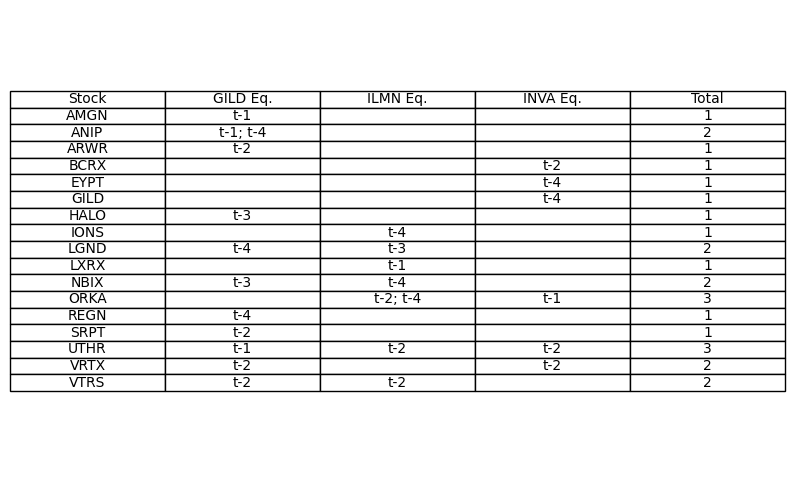

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'Stock': ['AMGN', 'ANIP', 'ARWR', 'BCRX', 'EYPT', 'GILD', 'HALO', 'IONS', 'LGND', 'LXRX', 'NBIX', 'ORKA', 'REGN', 'SRPT', 'UTHR', 'VRTX', 'VTRS'],
    'GILD Eq.': ['t-1', 't-1; t-4', 't-2', '', '', '', 't-3', '', 't-4', '', 't-3', '', 't-4', 't-2', 't-1', 't-2', 't-2'],
    'ILMN Eq.': ['', '', '', '', '', '', '', 't-4', 't-3', 't-1', 't-4', 't-2; t-4', '', '', 't-2', '', 't-2'],
    'INVA Eq.': ['', '', '', 't-2', 't-4', 't-4', '', '', '', '', '', 't-1', '', '', 't-2', 't-2', ''],
    'Total': [1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 3, 1, 1, 3, 2, 2]
}

df = pd.DataFrame(data)
plt.figure(figsize=(10, 6))
plt.axis('off')
plt.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')
plt.savefig('stock_counts.png', dpi=300, bbox_inches='tight')